# Digit Recognizer in Python using Convolutional Neural Nets

by [Koba Khitalishvili](http://www.kobakhit.com/)

## Introduction

I used Mathematica and a standard Neural Network model to get ~0.98 accuracy score after 40 minutes of computing. Starting with a brief benchmark Python code [found in the forums](https://www.kaggle.com/c/digit-recognizer/forums/t/2299/getting-started-python-sample-code-random-forest) one can jump into solving the Digit Recognizer
problem right away. Below code that uses Random Forest algorithm to classify images as digits will give you 
around 0.96 accuracy score in less than a minute which is great. However, this score will put you lower than the 200th place. 
According to [MNIST web page](http://yann.lecun.com/exdb/mnist/), convolutional neural networks algorithm yields good results.
I will try a simple neural network algorithm out in Python, expand it into a convolutional neural network and see if I can break into the top 100.

In [1]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# create the training & test sets, skipping the header row with [1:]
dataset = pd.read_csv("../mnist-data/train.csv")
target = dataset[[0]].values.ravel()
train = dataset.iloc[:,1:].values
test = pd.read_csv("../mnist-data/test.csv").values

# create and train the random forest
# multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train, target)
pred = rf.predict(test)

np.savetxt('submission_rand_forest.csv', \
           np.c_[range(1,len(test)+1),pred], delimiter=',', \
           header = 'ImageId,Label', comments = '', fmt='%d')

## Table of contents
1. Data Preprocessing
2. Train, Predict and Save
3. Conclusion

## Data Preprocessing
First, lets prepare the data. The `train.csv` has 42k rows. The first column is the digit labels. The rest 784 columns
are pixel color values that go from 0 to 255. After loading in the csv files in code section above, I saved the digit labels in the `target` variable and rows of pixel color values  in the `train` variable. 
The `test.csv` contains 28k rows of just the pixel color values which we need to classify as digits. Here is the preview of the complete MNIST dataset.

In [2]:
print(dataset.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         

I convert each data variable from a python list into a numpy array. For the `target` array I specify the integer data type.
The train set has 42k rows and 784 columns, so its shape is `(42k,784)`. Each row is a 28 by 28 pixel
picture. I will reshape the train set to have `(42k,1)` shape, i.e. each row will contain a 28 by 28 matrix of pixel color values. Same for the test set.

In [3]:
# convert to array, specify data type, and reshape
target = target.astype(np.uint8)
train = np.array(train).reshape((-1, 1, 28, 28)).astype(np.uint8)
test = np.array(test).reshape((-1, 1, 28, 28)).astype(np.uint8)

Now, we can actually plot those pixel color values and see what a sample picture of a digit looks like. Below is the picture of a digit in the 1729th row:

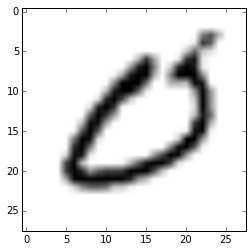

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.imshow(train[1729][0], cmap=cm.binary) # draw the picture

## Train, Predict and Save
Below is a simple NN set up. Supposedly, it should give >0.9 accuracy score. I had trouble with figuring out
the training part in that the accuracy I was getting would not change during the training process. All I had to 
do was to decrease the learning rate from 0.01 to 0.0001, nota bene.

In [5]:
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize

net1 = NeuralNet(
        layers=[('input', layers.InputLayer),
                ('hidden', layers.DenseLayer),
                ('output', layers.DenseLayer),
                ],
        # layer parameters:
        input_shape=(None,1,28,28),
        hidden_num_units=1000, # number of units in 'hidden' layer
        output_nonlinearity=lasagne.nonlinearities.softmax,
        output_num_units=10,  # 10 target values for the digits 0, 1, 2, ..., 9

        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=0.0001,
        update_momentum=0.9,

        max_epochs=15,
        verbose=1,
        )

//anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Now, lets train the model. 

In [6]:
# Train the network
net1.fit(train, target)

//anaconda/lib/python2.7/site-packages/nolearn/lasagne/base.py:428: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  for input_layer in input_layers]
//anaconda/lib/python2.7/site-packages/nolearn/lasagne/base.py:429: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  inputs = X_inputs + [theano.Param(y_batch, name="y")]
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '22719' (I am process '1421')


# Neural Network with 795010 learnable parameters

## Layer information

  #  name    size
---  ------  -------
  0  input   1x28x28
  1  hidden  1000
  2  output  10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       6.96745       2.02490      3.44089      0.92962  7.79s
      2       1.02433       1.51473      0.67625      0.93720  8.10s
      3       0.45578       1.28252      0.35538      0.93897  8.01s
      4       0.22336       1.30088      0.17170      0.93696  7.89s
      5       0.12570       1.09203      0.11511      0.94549  7.61s
      6       0.06349       1.02559      0.06191      0.94838  7.61s
      7       0.03274       0.98421      0.03326      0.95069  7.85s
      8       0.01843       0.98769      0.01866      0.95117  8.19s
      9       0.01186       1.02080      0.01162      0.94856  8.08s
     10       0.00547       0.97344      0.00562      0.95200  7.91s
     1

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x1290a7fd0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x1290a7f50>,
     custom_score=None, hidden_num_units=1000,
     input_shape=(None, 1, 28, 28),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=15, more_params={},
     objective=<function objective at 0x12909db90>,
     objective_loss_function=<function categorical_crossentropy at 0x128ec4de8>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x1290a9ea8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x1290be830>],
     output_nonlinearity=<function softmax at 0x128d40de8>,
     output_num_units=10, regression=False,
     train_split=

You can see the output associated with the training process. Right off the bat this set up gives us ~0.95 accuracy
score in just 15 epochs which completes in less than 3 minutes. Unfortunately, one layer neural network does not improve 
beyond 0.96 accuracy score ragardless of how many neurons in a layer is specified (1000 in case above).

I will try out the convolutional neural network. To set up the CNN I added two convolutional layers and one pooling layer. 
I would add another pooling layer and a dropout layer, but training such a model would last for over 20 minutes and kaggle notebook is only allowed to run for 1200 seconds (20 minutes). 
As a result, below is the CNN model I will use for demonstration.

In [8]:
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv2', layers.Conv2DLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],

    input_shape=(None, 1, 28, 28),
    conv1_num_filters=7, 
    conv1_filter_size=(3, 3), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    conv2_num_filters=12, 
    conv2_filter_size=(2, 2),    
    conv2_nonlinearity=lasagne.nonlinearities.rectify,
        
    hidden3_num_units=1000,
    output_num_units=10, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(15).fit(train,target) # train the CNN model for 15 epochs


# Neural Network with 1739428 learnable parameters

## Layer information

  #  name     size
---  -------  --------
  0  input    1x28x28
  1  conv1    7x26x26
  2  pool1    7x13x13
  3  conv2    12x12x12
  4  hidden3  1000
  5  output   10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.22636       0.42536      5.23401      0.86741  33.92s
      2       0.32667       0.28545      1.14440      0.91032  33.75s
      3       0.23419       0.22900      1.02265      0.92927  33.60s
      4       0.18815       0.19794      0.95057      0.93945  33.28s
      5       0.15920       0.17785      0.89513      0.94448  34.48s
      6       0.13858       0.16391      0.84546      0.94945  34.36s
      7       0.12283       0.15354      0.80000      0.95282  36.05s
      8       0.11021       0.14528      0.75862      0.95519  37.92s
      9       0.09963       0.13846      0.71954      0.95720

/Users/Koba/.ssh/src/lasagne/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


Looks like this CNN model produces a slightly better result than a simple NN model for the same number of epochs and neurons in the hidden layer. 
The CNN model was more time consuming though. If you think that it is not worth it to use the CNN model over the NN you are wrong.
NN model like any other has an upper bound on the best accuracy score it can produce. After 20 epochs 
NN model does not improve beyond ~0.97 whereas a CNN model gets closer to one. I was able to break into
top 100 and get the 94th place by using two convolutional layers and two pooling layers which gave me 0.98614 accuracy
in about 5 hours. I will provide the code in the appendix.

So there you go. You have a starting point for using neural nets for image classification. 
If you expand on the info here and reach a score greater than 0.99 please drop a comment.
Now, lets use it on the test set and save the results.


In [9]:
# use the NN model to classify test data
pred = cnn.predict(test)

# save results
np.savetxt('submission_cnn.csv', np.c_[range(1,len(test)+1),pred], \
           delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')


## Conclusion
Python really stands out when it comes to solving data problems. Its quick, intuitive, well documented and has a big community.
However, its biggest drawback in my opinion is setting up the environment. My set up is [Jupyter Notebook](http://jupyter.org/) coupled 
with [Anaconda](https://www.continuum.io/downloads). Both are great tools, however, I ended up spending 
couple hours taking care of the dependencies (theano and lasagne) and the Windows environment variables. In contrast to Mathematica which 
has superb report generating options, setting up Python environment can be and was for me a tiring experience. Nevertheless, it pays off because 
Python framework is well developed for solving data problems. For instance, Mathematica does not even have a CNN
implementation available as of 11/4/2015 and everything is done under the hood whereas in a Python framework one 
can find almost any algorithm imaginable.

Among Python, R and Julia I beleive Python and R are most competitive data science technologies with Julia being 
in the process of maturing. Choosing Python over R and vica versa really has to do with either individual preference or
the suitability of the technology for the problem at hand. Python is more efficient than R. But Julia is more 
efficient than both Python and R.


### Resources Used:

[Convolutional Neural Networks (LeNet)](http://deeplearning.net/tutorial/lenet.html)

[CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)

[Tutorial: Training convolutional neural networks with nolearn](http://nbviewer.ipython.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb)

[Using convolutional neural nets to detect facial keypoints tutorial](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/)

[Deep learning – Convolutional neural networks and feature extraction with Python](http://blog.christianperone.com/2015/08/convolutional-neural-networks-and-feature-extraction-with-python/)

# Appendix
## CNN that achieved 98.6% accuracy on test data

In [ ]:
import numpy as np
import pandas as pd

import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize

def main():
    print("Loading in data")
    # create the training & test sets, skipping the header row with [1:]
    dataset = pd.read_csv("train.csv")
    target = dataset[[0]].values.ravel()
    train = dataset.iloc[:,1:].values
    test = pd.read_csv("test.csv").values

    # convert to array, specify data type, and reshape
    target = target.astype(np.uint8)
    train = np.array(train).reshape((-1, 1, 28, 28)).astype(np.uint8)
    test = np.array(test).reshape((-1, 1, 28, 28)).astype(np.uint8)
    print("training model")
    # model set up
    def CNN(n_epochs):
        net1 = NeuralNet(
            layers=[('input', layers.InputLayer),
                ('conv2d1', layers.Conv2DLayer),
                ('maxpool1', layers.MaxPool2DLayer),
                ('conv2d2', layers.Conv2DLayer),
                ('maxpool2', layers.MaxPool2DLayer),
                ('dropout1', layers.DropoutLayer),
                ('dense', layers.DenseLayer),
                ('dropout2', layers.DropoutLayer),
                ('output', layers.DenseLayer),
                ],
         # input layer
         input_shape=(None, 1, 28, 28),
         # layer conv2d1
         conv2d1_num_filters=32,
         conv2d1_filter_size=(5, 5),
           conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
         conv2d1_W=lasagne.init.GlorotUniform(),  
         # layer maxpool1
         maxpool1_pool_size=(2, 2),    
         # layer conv2d2
         conv2d2_num_filters=32,
         conv2d2_filter_size=(5, 5),
         conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
         # layer maxpool2
         maxpool2_pool_size=(2, 2),
         # dropout1
         dropout1_p=0.5,    
         # dense
         dense_num_units=5000,
         dense_nonlinearity=lasagne.nonlinearities.rectify,    
         # dropout2
         dropout2_p=0.5,    
         # output
         output_nonlinearity=lasagne.nonlinearities.softmax,
         output_num_units=10,
         # optimization method params
         update=nesterov_momentum,
         update_learning_rate=0.0001,
         update_momentum=0.9,
         max_epochs=n_epochs,
         verbose=1)

        return net1

    # train model
    cnn = CNN(100).fit(train,target)

    # use the CNN model to classify test data
    pred = cnn.predict(test)

    # save results
    np.savetxt('submission_cnn.csv', np.c_[range(1,len(test)+1),pred], \
               delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')

if __name__ == "__main__":
    main()

